In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.kernel_approximation import RBFSampler

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import pandas as pd

import time

In [2]:
D_OUT = 5000

# Load original features and scaling coefficients

In [3]:
from lightonml.datasets import FashionMNIST

ImportError: No module named 'lightonml'

In [3]:
# (train_data, train_labels), (test_data, test_labels) = FashionMNIST()

train_data = np.load('../../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy').astype('uint8')
test_data = np.load('../../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy').astype('uint8')
train_labels = np.load('../../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy').astype('uint8')
test_labels = np.load('../../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy').astype('uint8')

# Convert one-hot to integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)
test_data = test_data.reshape(-1, D)

In [4]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0).astype('uint8')
    return data_bin

In [5]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold)
test_data_bin = threshold_binarize(test_data, threshold)

In [6]:
active_pixels_train = train_data_bin.sum(axis=1, keepdims=True)
active_pixels_test = test_data_bin.sum(axis=1, keepdims=True)

## Load synthetic opu features

In [14]:
class OPUModuleNumpy(object):
    def __init__(self, input_features, output_features, exponent=1, initial_log_scale='auto', dtype='float32'):
        super(OPUModuleNumpy, self).__init__()
        
        self.real_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        self.img_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        
        self.exponent = exponent
        
        if initial_log_scale == 'auto':
            self.log_scale = -0.5 * np.log(input_features)
        else:
            self.log_scale = initial_log_scale
        
    def project(self, data, matrix):
        return np.dot(data, matrix)
        
    def forward(self, data):
        out_real = self.project(data, self.real_matrix) ** 2
        out_img = self.project(data, self.img_matrix) ** 2
        
        output = (out_real + out_img) ** self.exponent

        return np.exp(self.log_scale) * output

In [8]:
opm = OPUModuleNumpy(784, D_OUT)

In [9]:
np_projection = opm.forward(np.vstack([train_data_bin, test_data_bin]))

## Optimize Ridge Classifier on them

In [13]:
raw_scale = (np_projection / np.vstack([active_pixels_train, active_pixels_test])).mean()

In [14]:
raw_scale

0.03596806274069604

In [15]:
# raw_scale should be 2*0.5 * 1. / sqrt(D_in)
1. / np.sqrt(784)

0.03571428571428571

In [17]:
parameters = {'alpha':[0.1, 1, 10, 100]}

In [22]:
for variance in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    since = time.time()
    
    factor = variance / raw_scale
    
    model = RidgeClassifier()
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=4)
    
    clf.fit(factor * np_projection[:60000], train_labels)
    print(variance, clf.cv_results_['mean_test_score'])
    
    print('Time per var.', time.time() - since)

/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.05597e-09): result may not be accurate.
  overwrite_a=True).T


1 [0.8826     0.8826     0.8826     0.88263333]
Time per var. 306.11516761779785


/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.05667e-09): result may not be accurate.
  overwrite_a=True).T


0.1 [0.88263333 0.88261667 0.88263333 0.88261667]
Time per var. 308.7742567062378


/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.43105e-09): result may not be accurate.
  overwrite_a=True).T


0.01 [0.88265    0.8826     0.88265    0.88331667]
Time per var. 309.9567701816559


/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.07729e-08): result may not be accurate.
  overwrite_a=True).T


0.001 [0.88268333 0.8833     0.88495    0.88365   ]
Time per var. 311.6124882698059


/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.07734e-08): result may not be accurate.
  overwrite_a=True).T


0.0001 [0.88493333 0.88365    0.8721     0.84686667]
Time per var. 311.84861516952515
1e-05 [0.8721     0.84686667 0.80808333 0.75725   ]
Time per var. 307.1119968891144


In [30]:
# test score
variance = 0.001
alpha = 10

factor = variance / raw_scale

clf = RidgeClassifier(alpha=alpha)
clf.fit(factor * np_projection[:60000], train_labels)
print(clf.score(factor * np_projection[60000:], test_labels))

/data/alpha/jonas-wacker/opu-venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.07729e-08): result may not be accurate.
  overwrite_a=True).T


0.8815


## Order 2 features

In [15]:
opm = OPUModuleNumpy(784, D_OUT, exponent=2)

In [16]:
np_projection = opm.forward(np.vstack([train_data_bin, test_data_bin]))

In [17]:
raw_scale = (np_projection / np.vstack([active_pixels_train, active_pixels_test]) ** 2).mean()

In [18]:
raw_scale

0.070592279166249

In [19]:
parameters = {'alpha':[0.1, 1, 10, 100]}

In [20]:
for variance in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    since = time.time()
    
    factor = variance / raw_scale
    
    model = RidgeClassifier()
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=4)
    
    clf.fit(factor * np_projection[:60000], train_labels)
    print(variance, clf.cv_results_['mean_test_score'])
    
    print('Time per var.', time.time() - since)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79269e-09): result may not be accurate.
  overwrite_a=True).T


1 [0.88 0.88 0.88 0.88]
Time per var. 57.45118069648743


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79268e-09): result may not be accurate.
  overwrite_a=True).T


0.1 [0.87998333 0.87998333 0.87998333 0.87998333]
Time per var. 55.331276178359985


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79268e-09): result may not be accurate.
  overwrite_a=True).T


0.01 [0.87998333 0.87998333 0.87998333 0.87998333]
Time per var. 54.50607419013977


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79269e-09): result may not be accurate.
  overwrite_a=True).T


0.001 [0.87998333 0.87998333 0.88       0.88      ]
Time per var. 55.03240895271301


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79275e-09): result may not be accurate.
  overwrite_a=True).T


0.0001 [0.87996667 0.87998333 0.87998333 0.87995   ]
Time per var. 54.94945311546326
1e-05 [0.88       0.87996667 0.88001667 0.88018333]
Time per var. 54.76183581352234


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.47604e-09): result may not be accurate.
  overwrite_a=True).T


In [21]:
for variance in [1, 0.1**2, 0.01**2, 0.001**2, 0.0001**2, 0.00001**2]:
    since = time.time()
    
    factor = variance / raw_scale
    
    model = RidgeClassifier()
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=4)
    
    clf.fit(factor * np_projection[:60000], train_labels)
    print(variance, clf.cv_results_['mean_test_score'])
    
    print('Time per var.', time.time() - since)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79269e-09): result may not be accurate.
  overwrite_a=True).T


1 [0.88 0.88 0.88 0.88]
Time per var. 52.95144844055176


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79268e-09): result may not be accurate.
  overwrite_a=True).T


0.010000000000000002 [0.87998333 0.87998333 0.87998333 0.87998333]
Time per var. 54.461021184921265


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79275e-09): result may not be accurate.
  overwrite_a=True).T


0.0001 [0.87996667 0.87998333 0.87998333 0.87995   ]
Time per var. 53.915048122406006


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.47605e-09): result may not be accurate.
  overwrite_a=True).T


1e-06 [0.88001667 0.88018333 0.87948333 0.87366667]
Time per var. 55.016069412231445
1e-08 [0.85848333 0.82463333 0.78471667 0.72273333]
Time per var. 54.01584219932556
1.0000000000000002e-10 [0.61525 0.51585 0.49365 0.4911 ]
Time per var. 53.84756255149841


## Do the same for the "real" OPU features

In [35]:
opu_features_train = np.load('fashion_mnist_features_opu/exposure_500/no_dummy/train_100K.npy')[:, :D_OUT]

In [36]:
opu_features_test = np.load('fashion_mnist_features_opu/exposure_500/no_dummy/test_100K.npy')[:, :D_OUT]

In [37]:
raw_scale_opu = (np.vstack([opu_features_train, opu_features_test]) / np.vstack([active_pixels_train, active_pixels_test])).mean()

In [38]:
raw_scale_opu

0.11141181042851421

In [39]:
for variance in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    since = time.time()
    
    factor = variance / raw_scale_opu
    
    model = RidgeClassifier()
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=4)
    
    clf.fit(factor * opu_features_train, train_labels)
    print(variance, clf.cv_results_['mean_test_score'])
    
    print('Time per var.', time.time() - since)

1 [0.87886667 0.87886667 0.87886667 0.87886667]
Time per var. 484.20058393478394
0.1 [0.87886667 0.87886667 0.87886667 0.87881667]
Time per var. 482.9742634296417
0.01 [0.87886667 0.87881667 0.87911667 0.87963333]
Time per var. 483.80264258384705
0.001 [0.87911667 0.87963333 0.8807     0.8754    ]
Time per var. 480.2423527240753
0.0001 [0.8807     0.8754     0.85951667 0.8282    ]
Time per var. 489.12343287467957
1e-05 [0.85951667 0.8282     0.7855     0.71005   ]
Time per var. 484.0654649734497


## RBF Optimization

In [7]:
from sklearn.kernel_approximation import RBFSampler

class RBFModuleNumpy(object):
    def __init__(self, input_features, output_features, gamma='auto', dtype='float32'):
        super(RBFModuleNumpy, self).__init__()
        
        if gamma=='auto':
            gamma = 1. / input_features
        
        self.sampler = RBFSampler(gamma=gamma, n_components=output_features, random_state=1)
        
    def forward(self, data):
        if not hasattr(self.sampler, 'random_weights_'):
            return self.sampler.fit_transform(data)
        else:
            return self.sampler.transform(data)

In [8]:
1 / 784

0.0012755102040816326

In [8]:
parameters = {'alpha':[0.1, 1, 10, 100]}

In [3]:
import pyDOE


d = 2

n = 10

samples = pyDOE.lhs(d,n,"maximin") 

In [5]:
import matplotlib.pyplot as plt

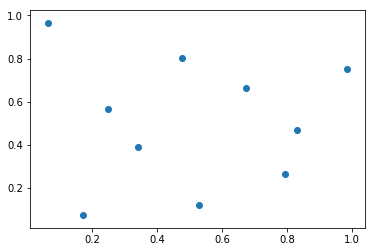

In [7]:
plt.scatter(samples[:,0], samples[:,1])

In [ ]:
# for gamma in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
for gamma in np.arange(0.001, 0.01, 0.001):
    print('-----------------------')
    print('Gamma: {}'.format(gamma))
    rbfm = RBFModuleNumpy(784, D_OUT, gamma=gamma)
    rbf_projection = rbfm.forward(train_data_bin)
    
    for variance in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
        since = time.time()

        model = RidgeClassifier()
        clf = GridSearchCV(model, parameters, cv=4, n_jobs=-1)

        clf.fit(variance * rbf_projection, train_labels)
        print('Variance: {}'.format(variance),  clf.cv_results_['mean_test_score'])
        print('Std test scores', clf.cv_results_['std_test_score'])

        print('Time per var.', time.time() - since)

-----------------------
Gamma: 0.001


In [ ]:
# Gamma: 0.005
# Variance: 0.0001 [0.86255    0.86255    0.86256667 0.86256667]

In [28]:
rbfm = RBFModuleNumpy(784, 10000, gamma=0.005)
rbf_projection = rbfm.forward(np.vstack([train_data_bin, test_data_bin]))
raw_scale_rbf = (rbf_projection / np.vstack([active_pixels_train, active_pixels_test])).mean()

In [29]:
# test score
variance = 0.0001
alpha = 10

factor = variance / raw_scale_rbf

clf = RidgeClassifier(alpha=alpha)
clf.fit(factor * rbf_projection[:60000], train_labels)
print(clf.score(factor * rbf_projection[60000:], test_labels))

0.8839


In [3]:
np.log(np.sqrt(1./(2*0.005)))

2.302585092994046

## GPy optimized parameters

In [18]:
rbf_variance = 0.1789329858438622
rbf_lengthscale = 7.1772554984593695
Gaussian_noise_variance = 0.04144662794391848

In [19]:
gamma = 1./(2*rbf_lengthscale**2)

In [20]:
rbfm = RBFModuleNumpy(784, D_OUT, gamma=gamma)
rbf_projection = rbfm.forward(np.vstack([train_data_bin, test_data_bin]))

In [22]:
clf = RidgeClassifier(alpha=Gaussian_noise_variance)
clf.fit(np.sqrt(rbf_variance) * rbf_projection[:60000], train_labels)
print(clf.score(np.sqrt(rbf_variance) * rbf_projection[60000:], test_labels))

0.8777
